In [1]:
import random
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('../input/ieee-cis-fraud-detection-advanced-fe/advanced_fe_train.pkl')
test_data = pd.read_pickle('../input/ieee-cis-fraud-detection-advanced-fe/advanced_fe_test.pkl')

In [3]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 309) 


 Test Data Shape : (506691, 308) 

*********************************************


In [4]:
with open("../input/ieee-cis-fraud-detection-advanced-fe/features_having_covariate_shift.pkl", 'rb') as handle:
  drop_cols = pickle.load(handle)

## Utility Functions
<br>

In [5]:
def tpr_fpr_threshold_auc(Y, proba):
    
    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, threshold, roc_auc)

In [6]:
#Reference: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''
    
    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [7]:
def best_threshold(threshold,tpr,fpr):
    
    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''
    
    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):
    
    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [8]:
#Reference: https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

def draw_confusion_matrix(Y, predicted):
    
    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [9]:
def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [10]:
X = train_data.drop(['isFraud']+drop_cols, axis=1)
y = train_data['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

In [11]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Cross Validation Data Shape : {} \n".format(X_cv.shape))
print("*"*45)

*********************************************

 Train Data Shape : (472430, 296) 


 Cross Validation Data Shape : (118108, 296) 

*********************************************


<br>

## Modeling

<br>

In [12]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

results = clf.fit(X_train, y_train, eval_set=[(X_cv, y_cv)], verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.78088
[50]	validation_0-auc:0.85989
[100]	validation_0-auc:0.87578
[150]	validation_0-auc:0.89143
[200]	validation_0-auc:0.90238
[250]	validation_0-auc:0.90995
[300]	validation_0-auc:0.91425
[350]	validation_0-auc:0.91682
[400]	validation_0-auc:0.91957
[450]	validation_0-auc:0.92126
[500]	validation_0-auc:0.92257
[550]	validation_0-auc:0.92360
[600]	validation_0-auc:0.92485
[650]	validation_0-auc:0.92604
[700]	validation_0-auc:0.92680
[750]	validation_0-auc:0.92749
[800]	validation_0-auc:0.92849
[850]	validation_0-auc:0.92907
[900]	validation_0-auc:0.92925
[950]	validation_0-auc:0.92968
[1000]	validation_0-auc:0.93017
[1050]	validation_0-auc:0.93060
[1100]	validation_0-auc:0.93112
[1150]	validation_0-auc:0.93118
[1200]	validation_0-auc:0.93114
[1238]	validation_0-auc:0.93109


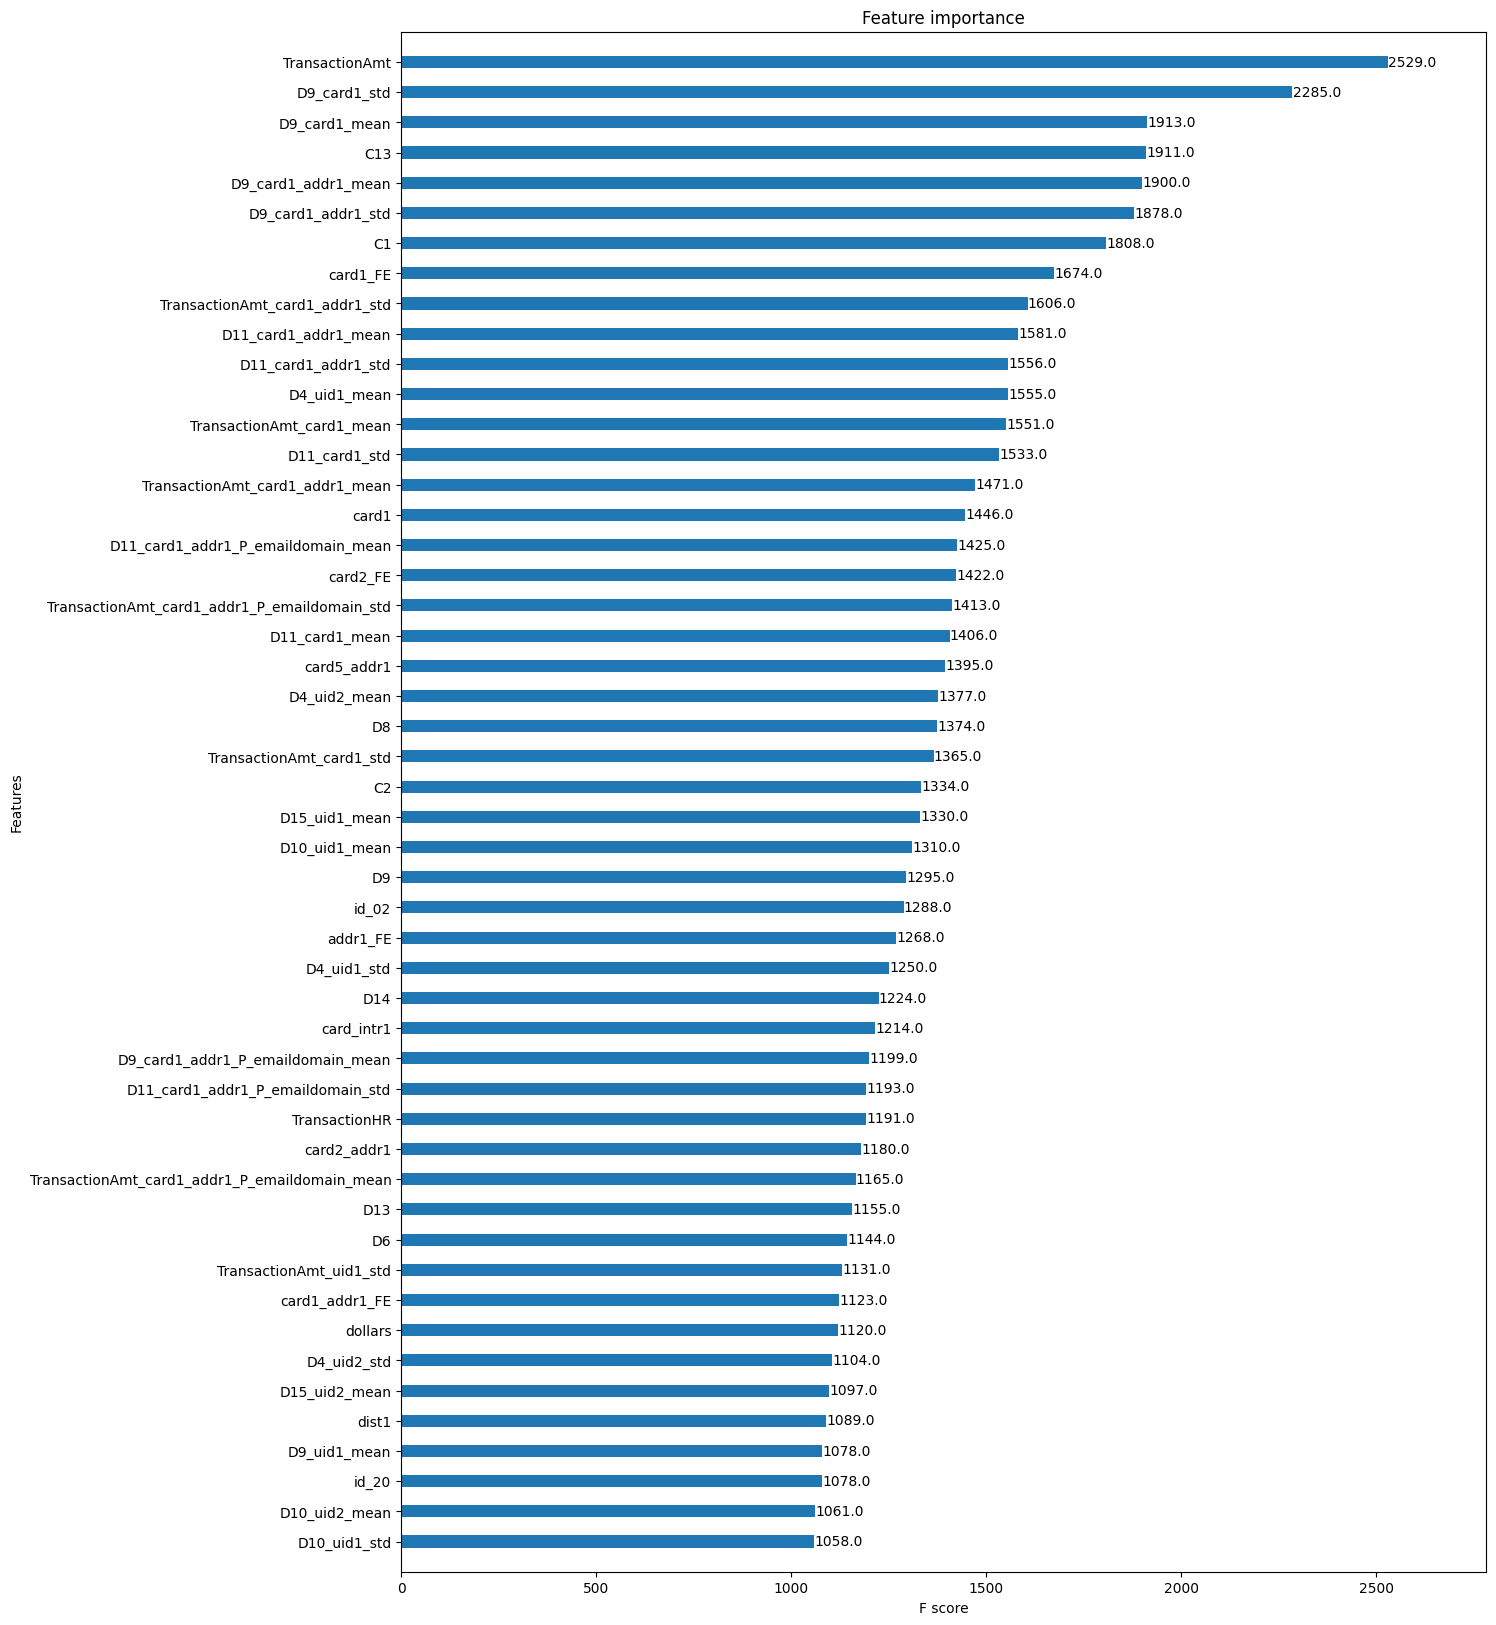

In [13]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [14]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]

In [15]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

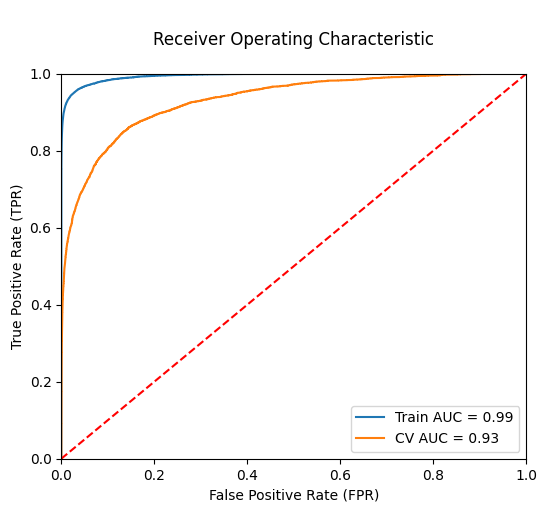

In [16]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

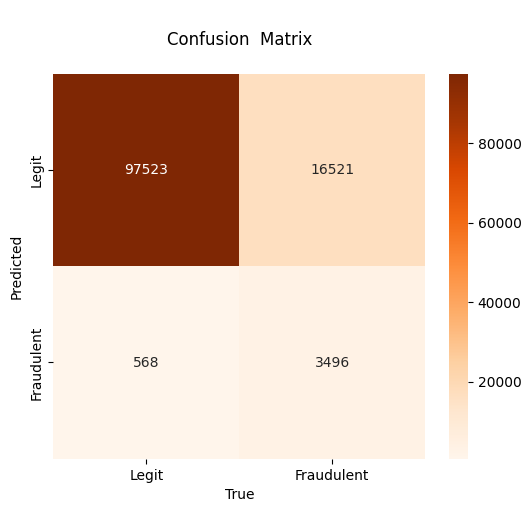

In [17]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)

In [18]:
del X_train, y_train

### Test Prediction
<br>

https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

We will predict test.csv using GroupKFold with months as groups. The training data are 12, 13, 14, 15, 16, 17. Fold one in GroupKFold will train on months 13 thru 17 and predict month 12. Note that the only purpose of month 12 is to tell XGB when to early_stop we don't actual care about the backwards time predictions. The model trained on months 13 thru 17 will also predict test.csv which is forward in time.

Note that we use local validation to determine features but GroupKFold to predict test.csv. Many other prediction schemes were tried but GroupKFold performed best.
<br><br>

In [19]:
X_train = train_data.drop('isFraud', axis=1)
y_train = train_data['isFraud']

X_test = test_data
test_ids = test_data['TransactionID'].values

cols = [f for f in X_train if f not in drop_cols]

del train_data, test_data

In [20]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Test Data Shape : {} \n".format(X_test.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590538, 308) 


 Test Data Shape : (506691, 308) 

*********************************************


In [21]:
# https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

test_proba = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)

for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0] 
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
  
    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=3000,
        tree_method='gpu_hist',
        random_state=3,
        subsample=0.8,
        max_depth=8,
        colsample_bytree=0.6,
        learning_rate=0.02
    )      

    h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
            verbose=100, early_stopping_rounds=200)

    test_proba += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits

Fold 0 withholding month 12
 rows of train = 453217 rows of holdout = 137321
[0]	validation_0-auc:0.78964
[100]	validation_0-auc:0.86137
[200]	validation_0-auc:0.88447
[300]	validation_0-auc:0.89648
[400]	validation_0-auc:0.90193
[500]	validation_0-auc:0.90469
[600]	validation_0-auc:0.90615
[700]	validation_0-auc:0.90753
[800]	validation_0-auc:0.90866
[900]	validation_0-auc:0.90914
[1000]	validation_0-auc:0.90965
[1100]	validation_0-auc:0.90959
[1200]	validation_0-auc:0.90969
[1300]	validation_0-auc:0.90989
[1400]	validation_0-auc:0.90973
[1500]	validation_0-auc:0.90956
[1507]	validation_0-auc:0.90943
Fold 1 withholding month 15
 rows of train = 488906 rows of holdout = 101632
[0]	validation_0-auc:0.79756
[100]	validation_0-auc:0.89164
[200]	validation_0-auc:0.91695
[300]	validation_0-auc:0.92805
[400]	validation_0-auc:0.93333
[500]	validation_0-auc:0.93654
[600]	validation_0-auc:0.93871
[700]	validation_0-auc:0.94022
[800]	validation_0-auc:0.94132
[900]	validation_0-auc:0.94203
[1000]

In [22]:
predict_and_save(test_proba, 'final_submission.csv')